In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [120]:
def linear_costs(x, y, z, theta):
    costs = (np.matmul(x,theta)-z)*(1-2*y)
    return costs

In [241]:
def paired_classifier(x, costs):
    for cost in costs.T:
        f.append(LinearRegression().fit(x, cost))
    return f

In [288]:
def obj_grad(objective, x, z, theta, n):
    if objective=='MSE':
        grad = (2/n)*np.matmul(x.T,np.matmul(x,theta)-z)
        return grad.flatten()
    elif objective=='dot_product':
        grad = (1/n)*np.matmul(x.T,z)
        return grad.flatten()
    else:
        return 0

In [372]:
def linear_proxies(x, y, z, C, iters, n, objective=None):
    zhat = LinearRegression().fit(x, z)
    theta = [np.transpose(zhat.coef_)]
    grad_l = []
    for t in range(1, iters):
        costs = linear_costs(x, y, z, theta[t-1])
        f_s = paired_classifier(x, costs)
        val = []
        h= [0]*n
        for i, f in enumerate(f_s):
            h_s = f.predict(x)
            h[i] = h_s < 0
            val.append(np.sum(h_s[h[i]]))
        y_index = np.argmin(val)
        y_temp = y[:,y_index]
        h = h[y_index].astype(int)
        if np.abs(np.sum(np.matmul(x,theta[t-1]))/np.sum(z) - 1) >= np.abs(np.matmul((np.matmul(x,theta[t-1])-z).T,np.abs(h-y_temp))):
            penalty = np.sign(np.sum(np.matmul(x,theta[t-1]))/np.sum(z) - 1) * np.sum(x, axis=0)/np.sum(z)
        else:
            penalty = -np.sign(np.matmul(np.transpose(np.matmul(x,theta[t-1])-z),np.abs(h-y_temp))) * np.matmul(np.transpose(x),np.abs(h-y_temp))  
            penalty = penalty.flatten()
        grad_l.append(obj_grad(objective,x,z,theta[t-1],n) - C * penalty) 
        theta.append(theta[t-1] - (np.power(t, -1/2) * grad_l[t-1]).reshape(-1,1))
    return theta, grad_l

In [383]:
#np.random.seed(1)
n = 1000
m = 100
intercept = np.ones(n).reshape(-1,1)
x_train = np.transpose(np.random.rand(n,1)).reshape(-1,1)
x_train = np.hstack((intercept, x_train))
#y_train = np.round(np.random.rand(n).reshape(-1,1))
y_train = np.round(np.random.rand(n,m))
print(y_train)
z_train = np.round(np.random.rand(n).reshape(-1,1))

coefficients, gradients = linear_proxies(x_train, y_train, z_train, 1, 1000, n, objective='MSE')

[[1. 1. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 0. 1.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]]
[-281.00153235]
[303362.59219607]
[-507416.75493867]
[380661.21451095]
[-278116.66954184]
[172368.52429719]
[-135517.70093335]
[114319.96321521]
[-97086.0993304]
[92341.86266378]
[-77681.62201171]
[79567.30592365]
[-65427.27808018]
[71012.44099119]
[-56840.34133526]
[64803.34866725]
[-50422.58089049]
[60051.40773434]
[-45408.2259166]
[56274.42364432]
[-41360.59239058]
[53185.77795477]
[-38010.64510794]
[50603.37963527]
[-35182.73961246]
[48405.48756729]
[-32756.88919201]
[46507.34421086]
[-30648.08516353]
[44847.96094171]
[-28794.26532427]
[43382.23216187]
[-27148.96545201]
[42076.01681116]
[-25676.64618722]
[40902.95490989]
[-24349.61811515]
[39842.34106124]
[-23145.95840674]
[38877.66480876]
[-22048.06299945]
[37995.58467555]
[-21041.61782525]
[37185.19181819]
[-20114.85329659]
[36437.47166172]
[-19257.99452631]
[35744.9037171]
[-

[125.46607791]
[-15053.5749636]
[3076.07047587]
[-11071.07889851]
[6018.09779035]
[-7954.97896459]
[8314.6649225]
[-5514.49325709]
[10107.80246355]
[-3601.14830814]
[11508.07438302]
[-2099.33191454]
[12601.59736659]
[-918.96992674]
[13455.48359718]
[-24.81307015]
[13528.25289182]
[76.14882629]
[-14835.32479342]
[2969.98183243]
[-10929.61387607]
[5862.78739429]
[-7860.01832825]
[8131.25352269]
[-5445.41194524]
[9910.53626934]
[-3544.18020021]
[11306.33582351]
[-2045.54226819]
[12401.3597472]
[-866.29117871]
[12742.6301156]
[-490.34296979]
[12961.70407946]
[-236.72838601]
[13266.76013653]
[93.57663114]
[-14542.46656494]
[2904.12447114]
[-10733.45728302]
[5732.94100486]
[-7725.75364192]
[7961.95253089]
[-5348.80984978]
[9718.73278925]
[-3468.62876737]
[11103.54072414]
[-1979.87672703]
[12195.20808202]
[-803.19366528]
[12502.22044934]
[-466.3316629]
[12786.27600778]
[-144.58704779]
[13096.59690404]
[182.10671076]
[-14193.54973004]
[2896.6292787]
[-10490.11966691]
[5653.9554074]
[-7552.7505

[-3965.66485095]
[6951.52525486]
[-2443.15973211]
[8122.45046429]
[-1156.49977463]
[9110.60973937]
[-108.67869588]
[9491.89350154]
[283.02052567]
[-10260.72166837]
[2019.0805881]
[-7770.23226449]
[3941.53348321]


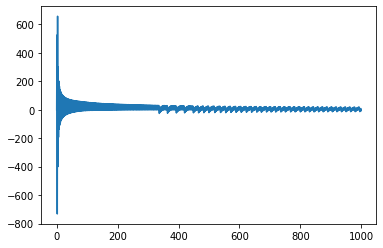

In [385]:
coefficients_0 = [row[0] for row in coefficients]
plt.plot(coefficients_0)

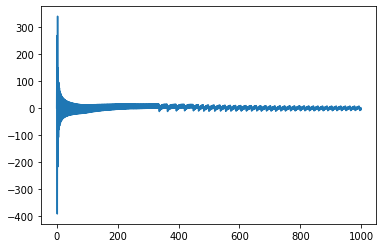

In [386]:
coefficients_1 = [row[1] for row in coefficients]
plt.plot(coefficients_1)

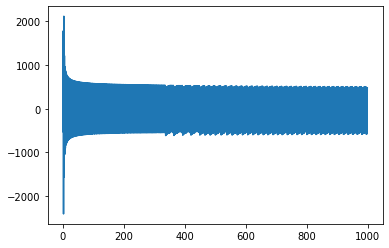

In [387]:
gradients_0 = [row[0] for row in gradients]
plt.plot(gradients_0)

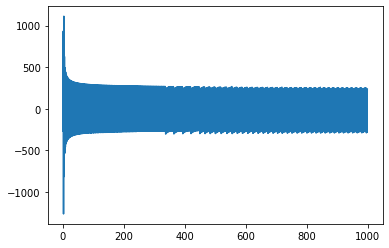

In [388]:
gradients_1 = [row[1] for row in gradients]
plt.plot(gradients_1)